In [387]:
!pip install ta --quiet

DEPRECATION: Loading egg at /Users/andysstuff/anaconda3/lib/python3.12/site-packages/sympy-1.13.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [389]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import requests

# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=1095)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Check available columns
# print("Columns:", amzn_data.columns)

   
# Get PE ratio from metadata
amzn = yf.Ticker("AMZN")
pe_ratio = amzn.info.get('trailingPE', None)

# If PE ratio is not available, set it to NaN
if pe_ratio is None:
    pe_ratio = float('nan')  # Set it to NaN for proper DataFrame handling
else:
    pe_ratio = float(pe_ratio)  # Ensure it's a float

# Create a Series for the PE ratio with the same date index as amzn_data
pe_series = pd.Series(pe_ratio, index=amzn_data.index)

# Combine the PE ratio Series with the historical data
amzn_data['PE_Ratio'] = pe_series

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

# Simulated sentiment based on daily percent change
if 'Adj Close' in amzn_data.columns:
    #MA past week
    amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean() 
    #MA past month
    amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
    #MA past year
    amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()

    amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()
    # amzn_data['Sentiment'] = amzn_data['Pct_Change'].apply(
    #     lambda x: 'Bullish' if x > 0 else ('Bearish' if x < 0 else 'Neutral')
    # )
else:
    print("⚠️ 'Adj Close' not found in the data. Cannot compute moving averages or sentiment.")

# # Replace with your Finnhub API key
# api_key = "d07ap6hr01qrslhn6ssgd07ap6hr01qrslhn6st0"
# # Ticker symbol for Amazon
# ticker = "AMZN"

# # Finnhub API endpoint for sentiment analysis
# url = f"https://finnhub.io/api/v1/news-sentiment?symbol={ticker}&token={api_key}"

# # Make the API request
# response = requests.get(url)

# sentiment_data = None
# # Check if the request was successful
# if response.status_code == 200:
#     sentiment_data = response.json()
#     print("Sentiment Data:", sentiment_data)
#     sentiment_score = sentiment_data["sentiment"]
#     amzn_data['Sentiment_score'] = sentiment_score
# else:
#     print("Failed to fetch sentiment data. Status code:", response.status_code)
#     amzn_data['Sentiment_score'] = float('nan')  # Set sentiment score to NaN if API fails


# Check available columns after adding metrics
# Now, modify the second index
new_columns = []

for col in amzn_data.columns:
    # Create a new tuple with the existing first index and 'AMZN' as the second index
    new_columns.append((col[0], 'AMZN'))

# Update the DataFrame's columns
amzn_data.columns = pd.MultiIndex.from_tuples(new_columns)

print("Columns:", amzn_data.columns)

# Display last few rows
print(len(amzn_data))
print(amzn_data.head())
print(amzn_data.tail())

[*********************100%***********************]  1 of 1 completed

Columns: MultiIndex([(    'Adj Close', 'AMZN'),
            (        'Close', 'AMZN'),
            (         'High', 'AMZN'),
            (          'Low', 'AMZN'),
            (         'Open', 'AMZN'),
            (       'Volume', 'AMZN'),
            (     'PE_Ratio', 'AMZN'),
            (   'Log_Return', 'AMZN'),
            ('Volatility_7d', 'AMZN'),
            (         'MA_7', 'AMZN'),
            (        'MA_30', 'AMZN'),
            (       'MA_365', 'AMZN'),
            (   'Pct_Change', 'AMZN')],
           )
750
             Adj Close       Close        High         Low        Open  \
                  AMZN        AMZN        AMZN        AMZN        AMZN   
Date                                                                     
2022-05-02  124.500000  124.500000  124.667999  118.375000  122.401001   
2022-05-03  124.253502  124.253502  126.220497  122.824997  124.053497   
2022-05-04  125.928497  125.928497  126.000000  119.182999  123.599998   
2022-05-05  116.406998

In [390]:
amzn_data.describe()
# print(len(amzn_data))

,Adj Close,Close,High,Low,Open,Volume,PE_Ratio,Log_Return,Volatility_7d,MA_7,MA_30,MA_365,Pct_Change
,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
count,750.000000,750.000000,750.000000,750.000000,750.000000,7.500000e+02,7.500000e+02,749.000000,743.000000,744.000000,721.000000,386.000000,749.000000
mean,149.824159,149.824159,151.700811,147.773949,149.777033,5.525736e+07,3.388087e+01,0.000548,0.020776,149.797332,149.881088,145.559743,0.000816
std,40.901739,40.901739,41.103389,40.613408,40.922484,2.574317e+07,1.350932e-13,0.023140,0.010096,40.819339,40.549874,23.345849,0.023190
min,81.820000,81.820000,83.480003,81.430000,82.800003,1.500750e+07,3.388087e+01,-0.094081,0.004918,83.874286,88.232667,114.283970,-0.089791
25%,115.002501,115.002501,116.912502,113.134998,114.730000,3.865912e+07,3.388087e+01,-0.012169,0.013895,114.924339,114.078334,122.125343,-0.012095
50%,142.260002,142.260002,143.470001,140.000000,141.670006,4.908670e+07,3.388087e+01,0.000413,0.018606,141.113573,136.950334,144.264370,0.000413
75%,183.810001,183.810001,185.889996,181.945000,183.834999,6.485058e+07,3.388087e+01,0.014053,0.024431,183.541787,183.438667,165.614452,0.014153
max,242.059998,242.059998,242.520004,238.029999,239.020004,2.231334e+08,3.388087e+01,0.114915,0.067685,237.695714,230.223333,186.330247,0.121778


In [391]:
amzn_data.info()
# print(len(amzn_data))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 2022-05-02 to 2025-04-28
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, AMZN)      750 non-null    float64
 1   (Close, AMZN)          750 non-null    float64
 2   (High, AMZN)           750 non-null    float64
 3   (Low, AMZN)            750 non-null    float64
 4   (Open, AMZN)           750 non-null    float64
 5   (Volume, AMZN)         750 non-null    int64  
 6   (PE_Ratio, AMZN)       750 non-null    float64
 7   (Log_Return, AMZN)     749 non-null    float64
 8   (Volatility_7d, AMZN)  743 non-null    float64
 9   (MA_7, AMZN)           744 non-null    float64
 10  (MA_30, AMZN)          721 non-null    float64
 11  (MA_365, AMZN)         386 non-null    float64
 12  (Pct_Change, AMZN)     749 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 82.0 KB


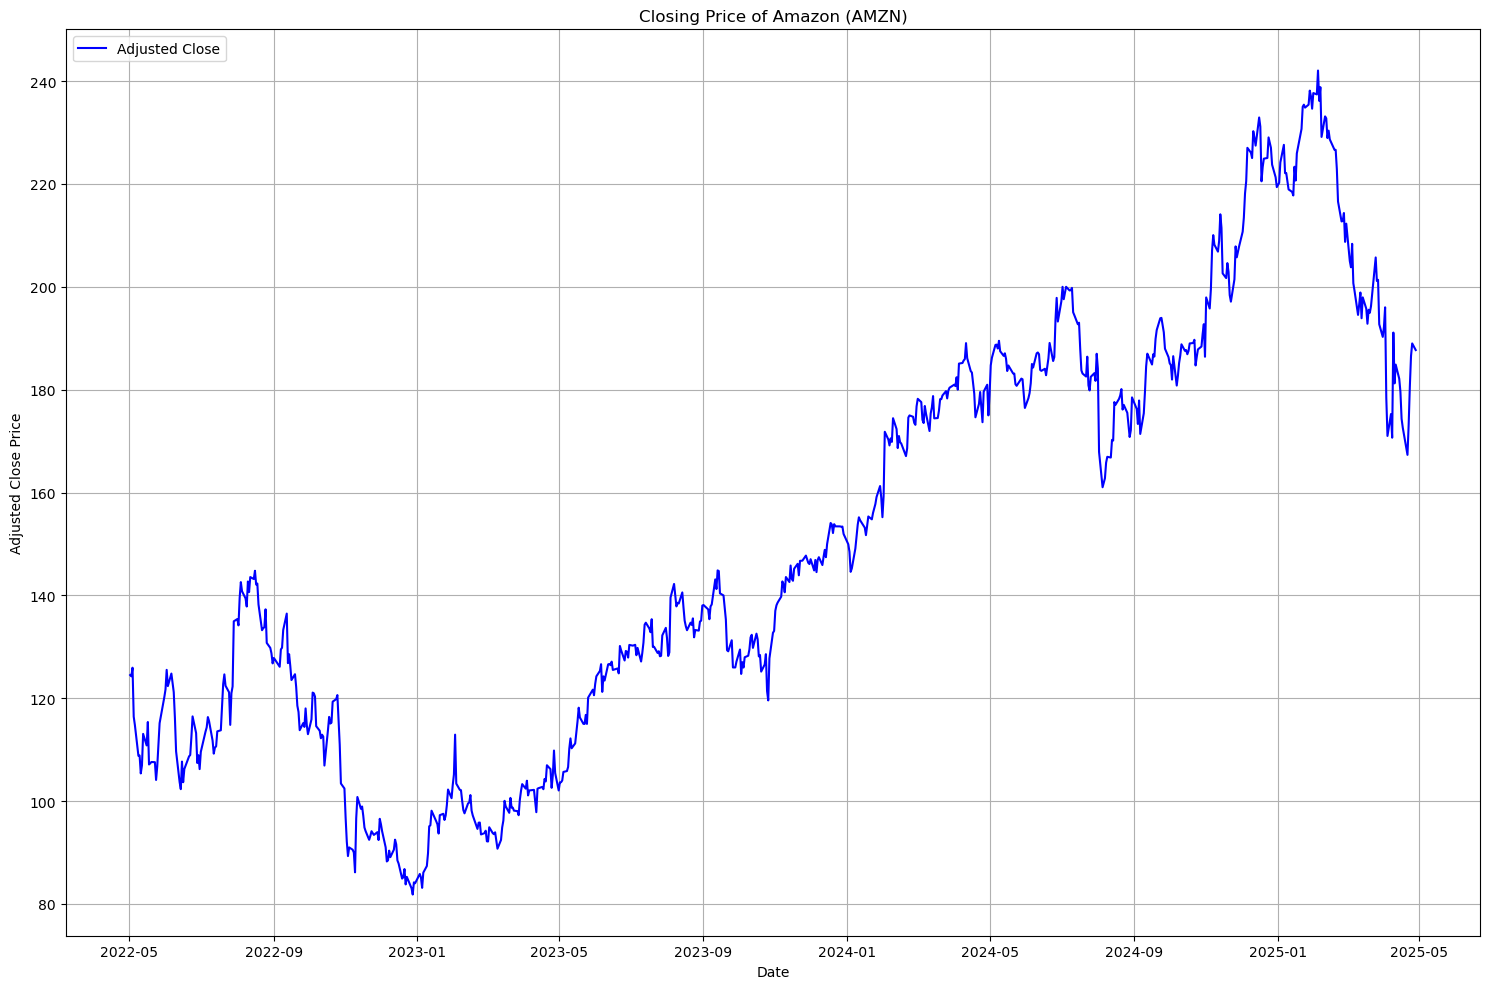

In [392]:

# Time range: past 3 years
# end_date = datetime.now()
# start_date = end_date - timedelta(days=1095)

# Download data for AMZN
# amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the adjusted closing price
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.title("Closing Price of Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()


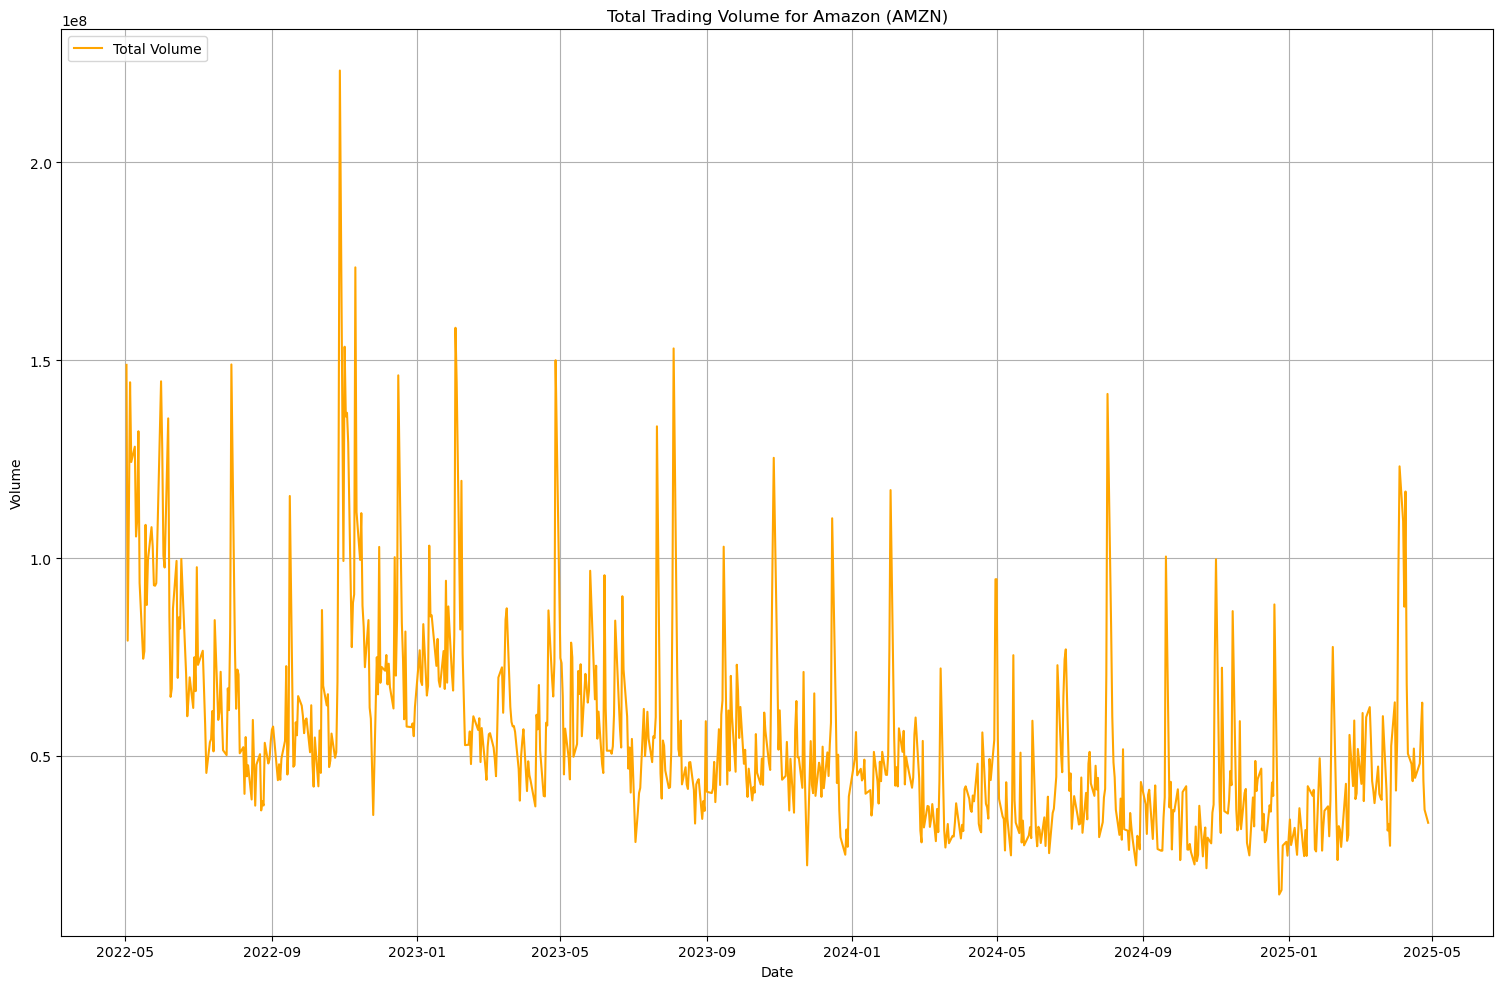

In [393]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Volume'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()

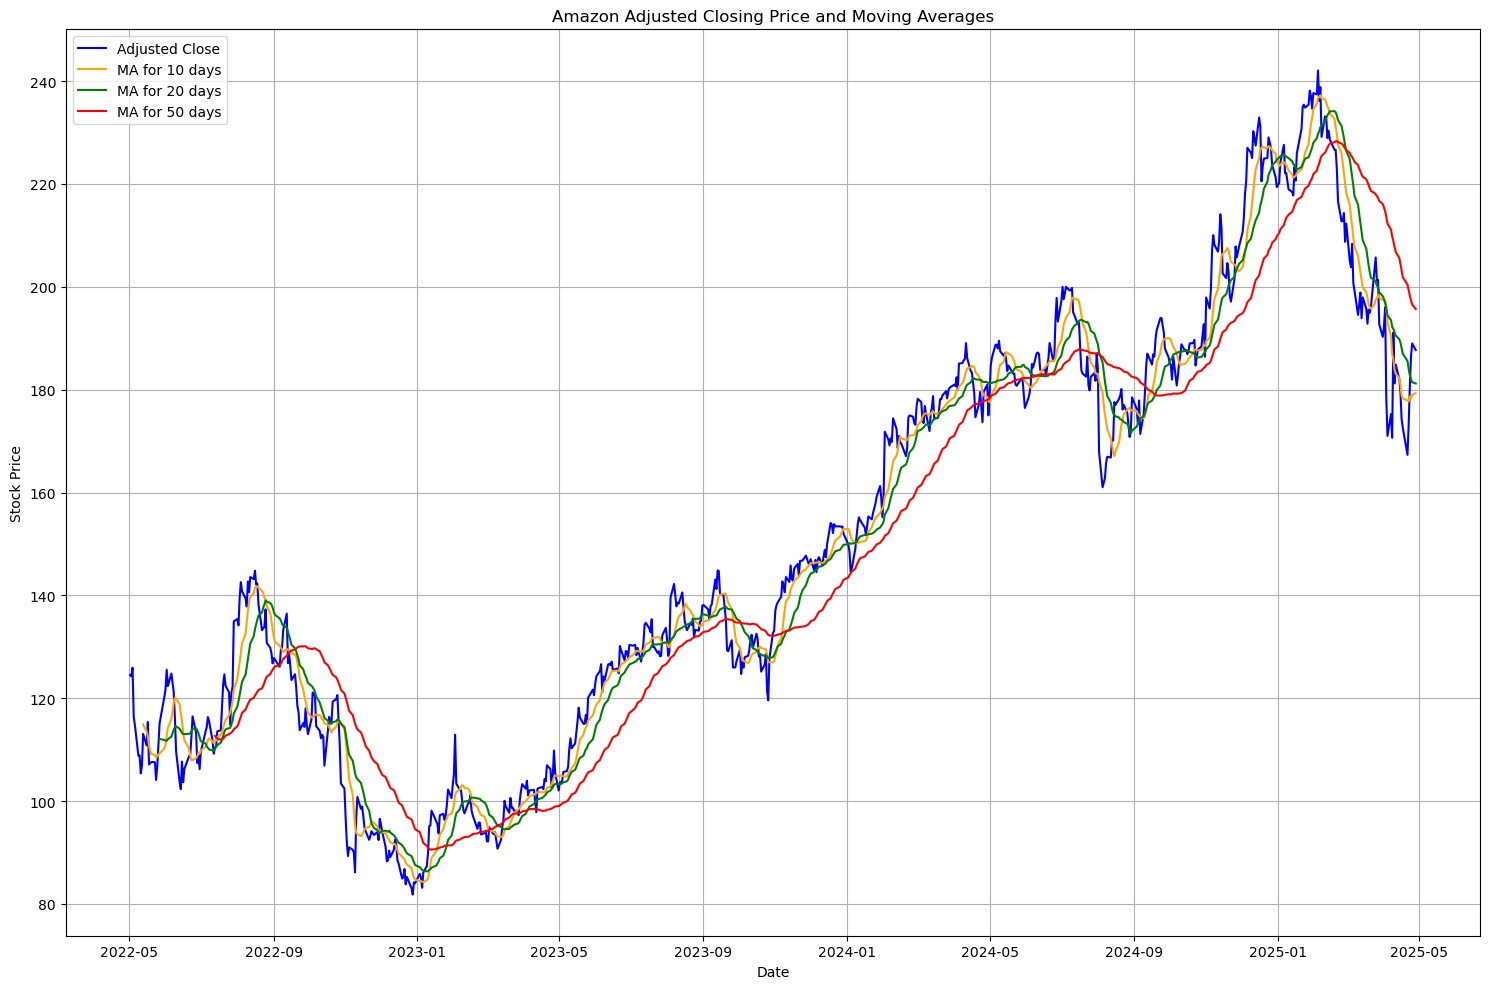

In [394]:
ma_day = [10, 20 ,50]
for ma in ma_day:
    amzn_data[f"MA for {ma} days"] = amzn_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA for 10 days'], label='MA for 10 days', color='orange')
plt.plot(amzn_data['MA for 20 days'], label='MA for 20 days', color='green')
plt.plot(amzn_data['MA for 50 days'], label='MA for 50 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


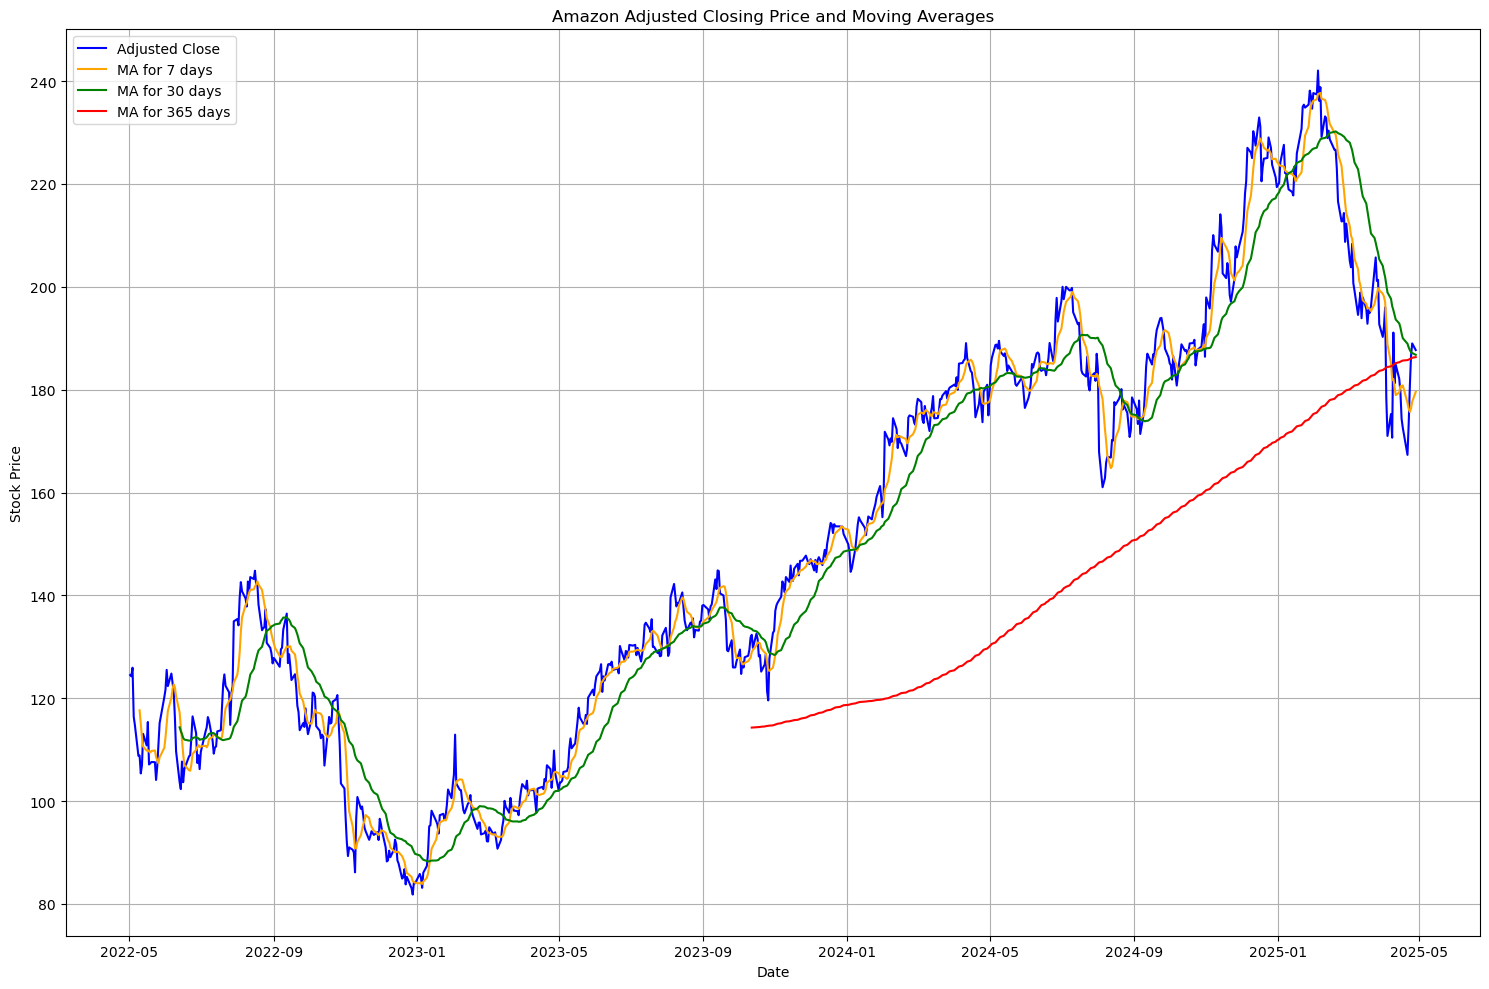

In [395]:

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA_7'], label='MA for 7 days', color='orange')
plt.plot(amzn_data['MA_30'], label='MA for 30 days', color='green')
plt.plot(amzn_data['MA_365'], label='MA for 365 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


750


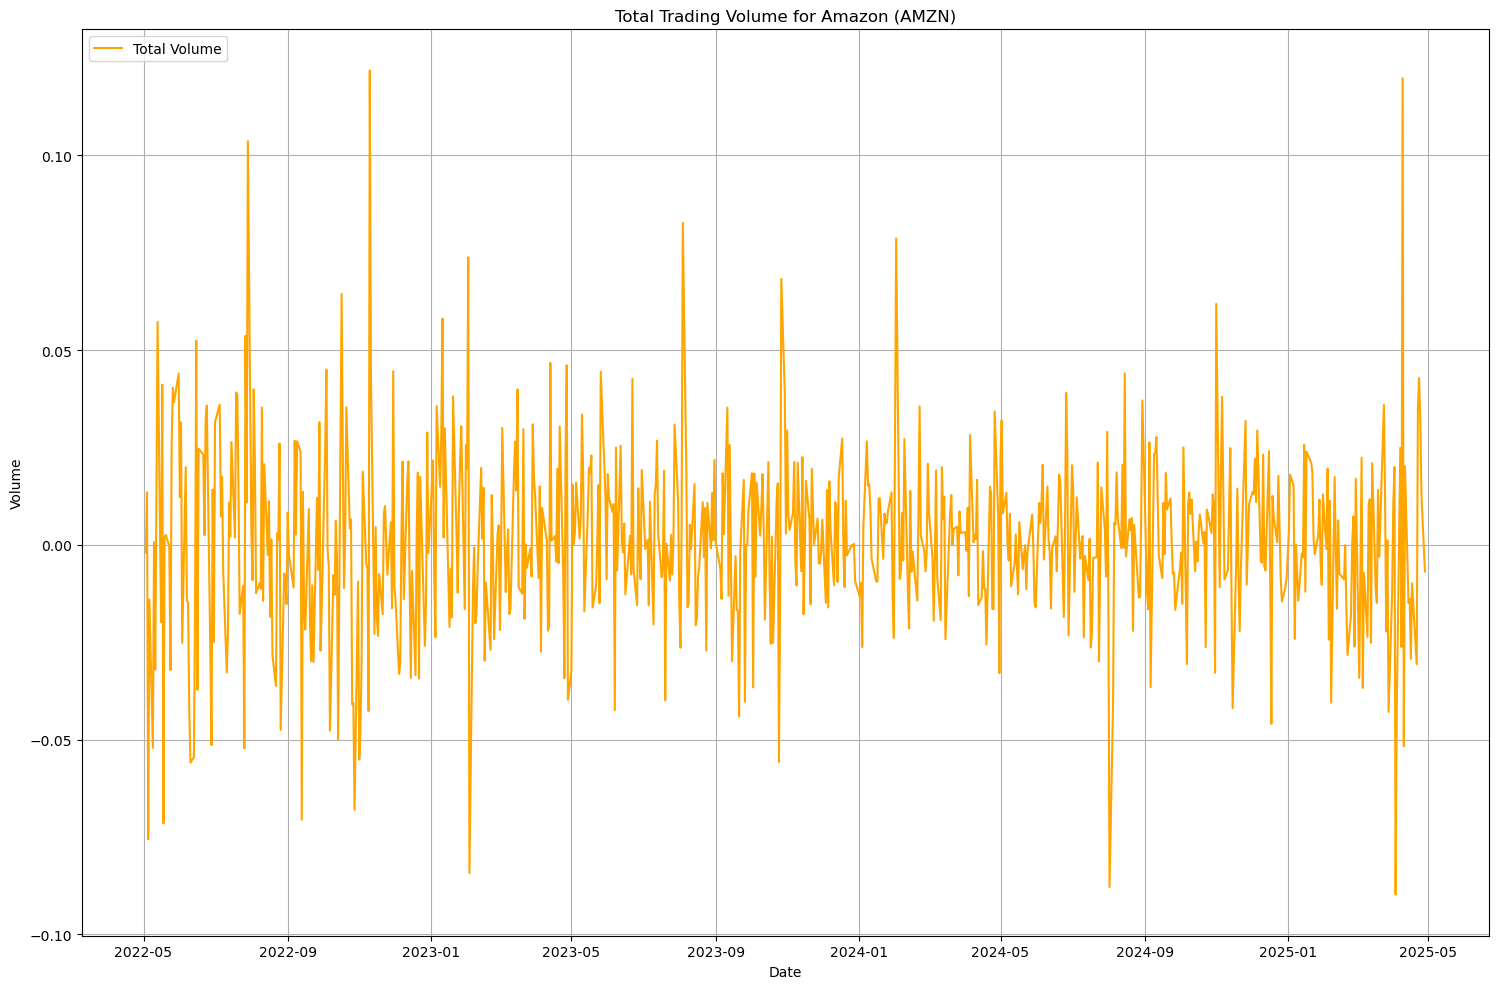

In [396]:
print(len(amzn_data))
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Pct_Change'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout() 
plt.show()

In [400]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Drop NaN values resulting from calculations

print(len(amzn_data))
# Drop NaN values resulting from calculations
amzn_data = amzn_data.dropna()

scaler = StandardScaler()
# Selecting features for training
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return', 'Pct_Change', 'MA_7', 'MA_30', 'MA_365', 'Volatility_7d', 'PE_Ratio']
data = amzn_data[features]

amzn_data[features] = scaler.fit_transform(amzn_data[features])

386


In [401]:
import joblib 

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [402]:
X = []
y = []
print(len(amzn_data))
# print(len(amzn_data))
time_steps = 30  # Lookback period
for i in range(time_steps, len(amzn_data)):
    # the line of code below adds all the features from the lookback start to the day before the current 
    X.append(amzn_data[features].iloc[i-time_steps:i].values)  # Use NumPy slicing instead of iloc
    # the line below adds only the 'closing price' feature to y on the currnet day that it's trying to predict
    y.append(amzn_data['Close'].iloc[i])

X, y = np.array(X), np.array(y)

# Train-test split for LSTM
# from sklearn.model_selection import train_test_split
# the 80% to 20% training-test split ensures that the predicted closing prices are not cheating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

386
(284, 30, 13)


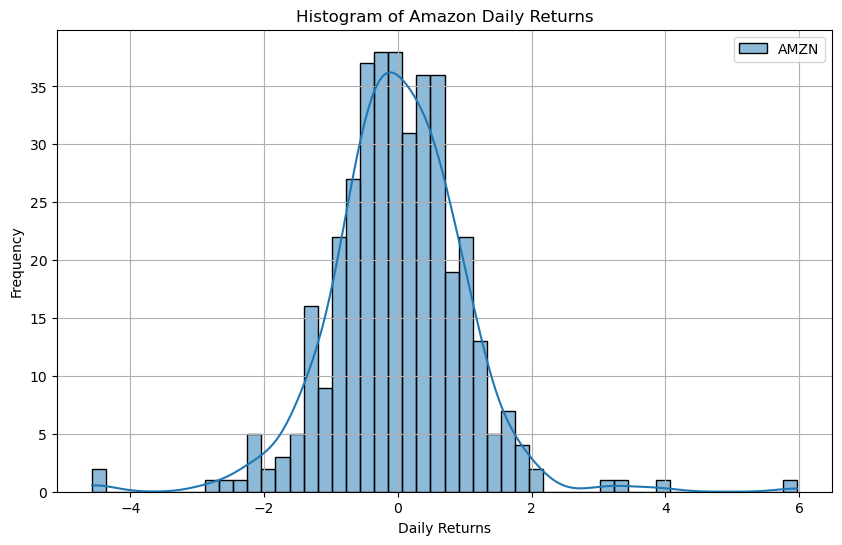

In [403]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(amzn_data['Pct_Change'].dropna(), bins=50, kde=True, color='seagreen')
plt.title('Histogram of Amazon Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()
  

In [356]:
# # Check the data     
# print(amzn_data['Sentiment'].describe())
# print(amzn_data['Sentiment'].head())
# print(amzn_data['Sentiment'].tail())


# # Handle missing or invalid data
# amzn_data['Sentiment'].dropna(inplace=True)

# print(amzn_data['Sentiment'].isnull().sum())
# amzn_data['Sentiment'].dropna(inplace=True)
# # print(amzn_data['Sentiment'].dtype)

# # Ensure sufficient data
# if len(amzn_data['Sentiment']) < 2:
#     raise ValueError("Not enough data points in 'Sentiment' column for plotting.")


MultiIndex([(     'Adj Close', 'AMZN'),
            (         'Close', 'AMZN'),
            (          'High', 'AMZN'),
            (           'Low', 'AMZN'),
            (          'Open', 'AMZN'),
            (        'Volume', 'AMZN'),
            (      'PE_Ratio', 'AMZN'),
            (    'Log_Return', 'AMZN'),
            ( 'Volatility_7d', 'AMZN'),
            (          'MA_7', 'AMZN'),
            (         'MA_30', 'AMZN'),
            (        'MA_365', 'AMZN'),
            (    'Pct_Change', 'AMZN'),
            ('MA for 10 days',     ''),
            ('MA for 20 days',     ''),
            ('MA for 50 days',     '')],
           )
           Adj Close     Close      High       Low      Open    Volume  \
                AMZN      AMZN      AMZN      AMZN      AMZN      AMZN   
Date                                                                     
2023-10-12 -1.970019 -1.970019 -1.945051 -1.946297 -1.967495  0.679532   
2023-10-13 -2.068028 -2.068028 -1.989753 -2.035252

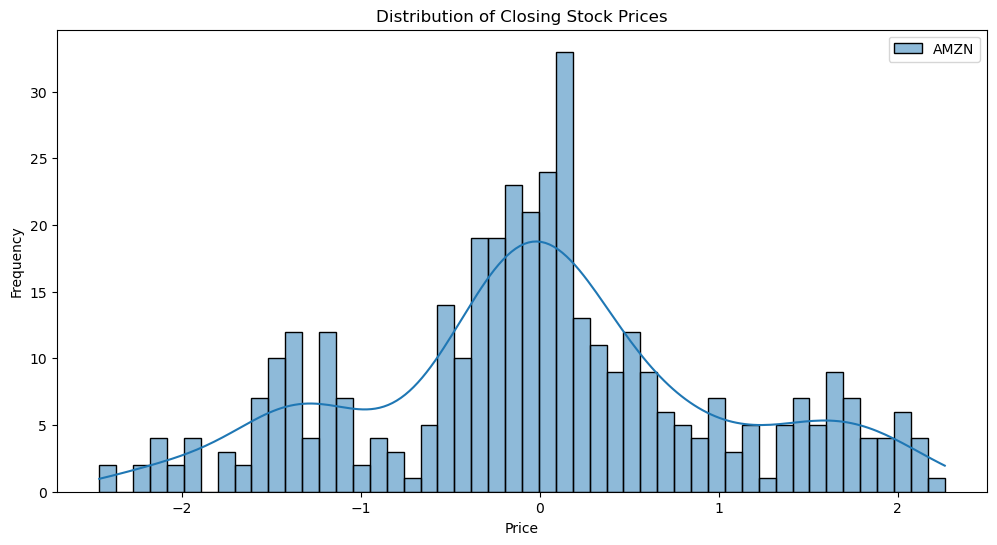

In [404]:
import seaborn as sns
import matplotlib.pyplot as plt
 

# Convert 'Close' column to numeric
# amzn_data['Close'] = pd.to_numeric(amzn_data['Close'], errors='coerce')
assert isinstance(amzn_data, pd.DataFrame)

print(amzn_data.columns)
# Drop rows with missing 'Close' values
# amzn_data = amzn_data.dropna(subset=['Close'])

print(amzn_data.head())
print(amzn_data.tail())
# Visualize the distribution of 'Close' prices
plt.figure(figsize=(12, 6))
sns.histplot(amzn_data['Close'], bins=50, kde=True, color='blue')
plt.title('Distribution of Closing Stock Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# # Visualize the 'Sentiment_Score'
# plt.figure(figsize=(12, 6))
# sns.histplot(amzn_data['Sentiment'], bins=50, kde=True, color='green')
# plt.title('Distribution of Sentiment Scores')
# plt.xlabel('Sentiment Score')
# plt.ylabel('Frequency')
# plt.show()


In [439]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Tuning the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))




Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.4439 - val_loss: 0.2046
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1991 - val_loss: 0.0764
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1218 - val_loss: 0.0724
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0782 - val_loss: 0.0542
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0658 - val_loss: 0.0423
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0589 - val_loss: 0.0474
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0507 - val_loss: 0.0371
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0509 - val_loss: 0.0362
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0473 - val_loss: 0.0342
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0366 - val_loss: 0.0345
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0304 - val_loss: 0.0367
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0328 - val_loss: 0.0345
Epoch 13/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


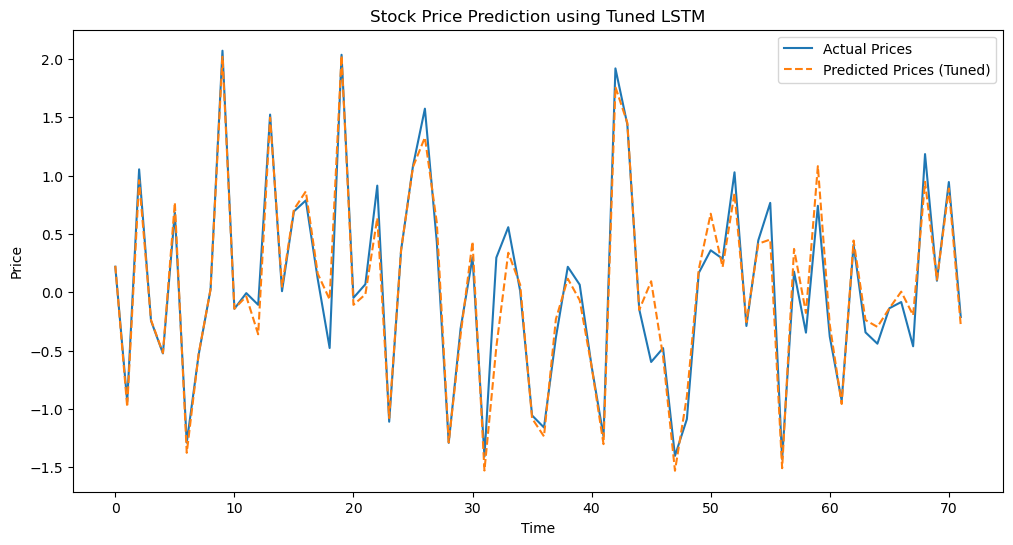

In [440]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model = model.predict(X_test)

# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()



In [441]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model)
r2 = r2_score(y_test, lstm_predictions_model)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.03287369660665849
Root Mean Squared Error (RMSE): 0.18131104932314104
Mean Absolute Error (MAE): 0.11459942001655514
R-squared (R²): 0.9527996625301364


In [442]:
# Tuning the LSTM model
model2 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3618 - val_loss: 0.0898
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1168 - val_loss: 0.0948
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0836 - val_loss: 0.0483
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0589 - val_loss: 0.0505
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0546 - val_loss: 0.0371
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0424 - val_loss: 0.0388
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0444 - val_loss: 0.0364
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0365 - val_loss: 0.0383
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0417 - val_loss: 0.0377
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0441 - val_loss: 0.0355
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0356 - val_loss: 0.0366
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0401 - val_loss: 0.0358
Epoch 13/50


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


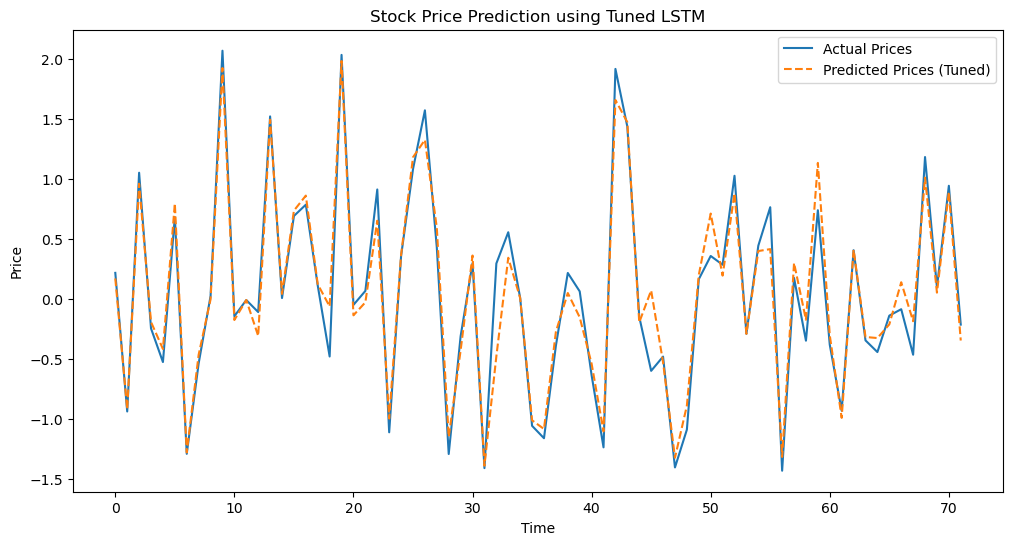

In [443]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model2 = model2.predict(X_test)

# lstm_predictions_model2 = lstm_predictions_model2[:, -1, 0]  
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [444]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model2)
r2 = r2_score(y_test, lstm_predictions_model2)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.03565730238549281
Root Mean Squared Error (RMSE): 0.18883141260259856
Mean Absolute Error (MAE): 0.12880357253101904
R-squared (R²): 0.9488029373149554


In [469]:
# Tuning the LSTM model
model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.23),
    LSTM(80, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 1.0282 - val_loss: 0.2198
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2252 - val_loss: 0.1381
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1672 - val_loss: 0.1102
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1407 - val_loss: 0.0932
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1237 - val_loss: 0.0747
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0876 - val_loss: 0.0569
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0728 - val_loss: 0.0524
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0642 - val_loss: 0.0530
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0639 - val_loss: 0.0444
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0529 - val_loss: 0.0465
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0494 - val_loss: 0.0436
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0559 - val_loss: 0.0412
Epoch 13/50

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


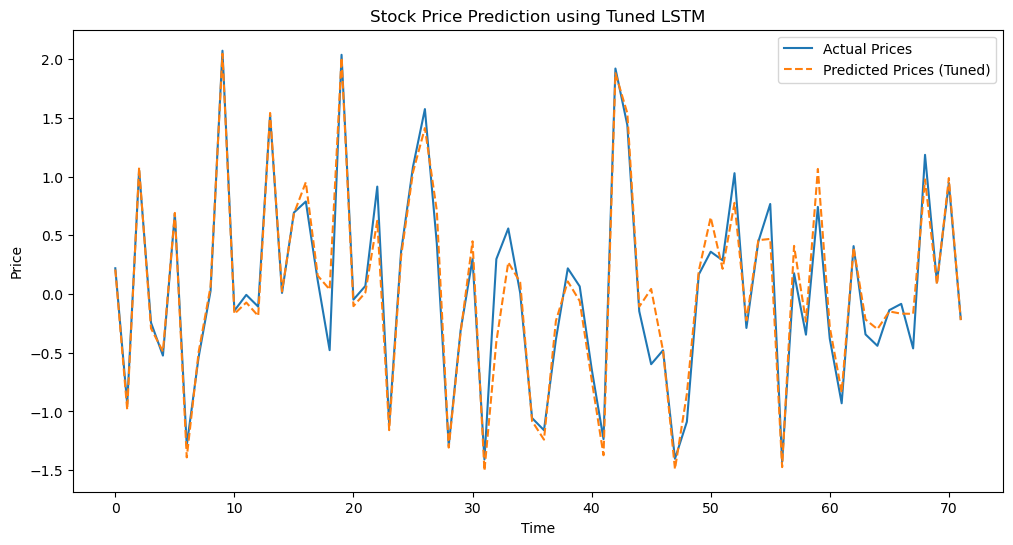

In [470]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model3 = model3.predict(X_test)

# lstm_predictions_model3 = lstm_predictions_model3[:, -1, 0]  
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [471]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model3)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model3)
r2 = r2_score(y_test, lstm_predictions_model3)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Mean Squared Error (MSE): 0.032493308302298934
Root Mean Squared Error (RMSE): 0.1802590033876226
Mean Absolute Error (MAE): 0.11713170712502155
R-squared (R²): 0.953345827342393


In [472]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

In [473]:
# convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

IndexError: arrays used as indices must be of integer (or boolean) type